In [19]:
# Definicion de features y carga de bases


import numpy as np, pandas as pd, geopandas as gpd
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------- 0) Helpers ----------
def parse_iso_week(yrwk:str):
    # 'YYYY-Www' -> lunes de esa semana
    return pd.to_datetime(yrwk + "-1", format="%G-W%V-%u")

def unique(seq):  # preserva orden
    return list(dict.fromkeys(seq))



def features_build(df_model):
    encuesta = ['CALMAT I','CALMAT II','CALMAT III','CALMAT IV','CALMAT V',
                'Acceso a Cloacas','Acceso a Gas de Red','Acceso a Agua de Red','Acceso a Electricidad']
    geografia = ['Superficie (Km cuadrados)',
                'Proximidad al río (m) (distancia mínima)',
                'Proximidad al río (m) (distancia al centroide)',
                'Proximidad al río (m) (distancia máxima)']
    poblacion = ['Estimación poblacional','Densidad poblacional']
    demo = ['Personas de 0 a 6 años','Mujeres de 0 a 6 años','Personas de 7 a 14 años','Personas de 15 a 24 años',
            'Personas de 25 a 59 años','Personas de 60 años o más','Mujeres de 15 a 24 años',
            'Mujeres de 25 a 59 años','Mujeres de 60 años o más','Mujeres de 7 a 14 años',
            'Varones de 0 a 6 años','Varones de 15 a 24 años','Varones de 25 a 59 años',
            'Varones de 60 años o más','Varones de 7 a 14 años','Mujeres (%)','Varones (%)']
    pobreza = ['Hogares Indigentes','Hogares Pobres','Hogares Pobres No Indigentes',
            'Personas Indigentes','Personas Pobres','Personas Pobres No Indigentes']
    educacion = ['UNEA: Primario Completo','UNEA: Primario Incompleto','UNEA: Secundario Incompleto',
                'UNEA: Sin Instrucción','UNEA: Superior y/o Universitario Incompleto',
                'UNEA: Secundario Completo','UNEA: Superior y/o Universitario Completo']

    acum = ['casos_sum_2w','casos_sum_3w','casos_sum_4w']
    lags = [f'casos_lag_{l}' for l in (1,2,3,4)]
    
    # df_model['mes'] = pd.to_datetime(df_model['f']+'-1', format='%G-W%V-%u').dt.month


    # tendencia simple

    # df_model['t'] = df_model.groupby('municerca').cumcount()

    prefixes = ("t2m_", "d2m_", "tp_")
    clima_cols = [c for c in df_model.columns if c.startswith(prefixes)]
    # clima_cols.remove("wind_speed")

    # clima_cols=["ws10_mean_1w","t2m_max_mean_1w","t2m_min_mean_1w","tp_mean_1w","d2m_mean_1w"]
    print(clima_cols)
    prefixes = ("vec_")
    vec_cols = [c for c in df_model.columns if c.startswith(prefixes)]

    vec_cols = ['Vecinos_total']

    # dic_ff={'Casos ma4 y mes':['casos_ma_4','mes'],'Clima':clima_cols,"Acumulado":acum,"lags":lags,'vecinos':vecinos,'geografia':geografia,'educacion':educacion}
    # bf1 = ['casos_ma_4','mes']+ clima_cols + acum + lags
    bf2 = ['casos_ma_4']+ clima_cols + acum + lags + vec_cols #+geografia +educacion#+encuesta#+pobreza#+ poblacion #+ demo + pobreza + educacion + encuesta 
    # bf3 = ['casos_ma_4','mes']+ clima_cols + acum + lags+ vecinos + geografia
    # bf4 = ['casos_ma_4','mes']+ clima_cols + acum + lags+ vecinos + geografia + educacion
    #demo, pobreza y encuesta empeora empeora mucho

    labels=["Con casos ma4, mes, clima, acumulados, y lags y Vecinos","Ant. + vecinos", "Ant. mas geografia","Ant. mas educacion"]
    dic_features={}
    # for i,b in enumerate([bf1,bf2,bf3,bf4]):
    for i,b in enumerate([bf2]):
  
        dic_features[labels[i]]=unique(b)

    print(dic_features)
    return(dic_features)


def load_data(g,d,t):

    df_datos_agg = pd.read_csv(r"outputs\casos_con_municerca"+g+"_"+d+"_"+t+".csv")

    df_datos_agg = df_datos_agg.sort_values(['municerca','fecha_agg']).reset_index(drop=True)
    df_model=df_datos_agg.copy()

    # df_model = df_model.sort_values(["fecha_agg","municerca"]).reset_index(drop=True)
    # df_model = df_model.sort_values(['municerca','fecha_agg'])
    features=features_build(df_model)

   # features = ['casos_ma_4','mes_sin','mes_cos','t'] + clima_cols + acum + lags + ['Vecinos_total']
    # quita filas sin todos los lags indispensables

   
    splits = list(make_week_splits_pos(df_model, n_splits=5))
    # sanity-check usando la MISMA lista (no consume)
    N = len(df_model)
    for k, (tr, te) in enumerate(splits, 1):
        assert tr.max() < N and te.max() < N, f"Fold {k}: índice fuera de rango"

    return(df_model,features,splits)

In [20]:
# Poisson si es que


from sklearn.compose import TransformedTargetRegressor
import numpy as np

def is_poisson_like(model):
    name = model.__class__.__name__.lower()
    if 'histgradientboostingregressor' in name:
        return getattr(model, 'loss', None) in ('poisson','gamma','tweedie')
    if 'xgbregressor' in name:
        obj = getattr(model, 'objective', None) or model.get_xgb_params().get('objective','')
        return any(k in str(obj).lower() for k in ['poisson','gamma','tweedie','count:poisson'])
    if 'lgbmregressor' in name:
        obj = getattr(model, 'objective', None)
        return obj is not None and any(k in str(obj).lower() for k in ['poisson','gamma','tweedie'])
    return False

def wrap_log1p_if_needed(model):
    # Poisson-like -> NO envolver
    if is_poisson_like(model):
        return model
    # Envolver con log1p/expm1 (stabiliza picos)
    return TransformedTargetRegressor(regressor=model,
                                      func=np.log1p,
                                      inverse_func=np.expm1)


import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, clone

class Log1pSmearingRegressor(BaseEstimator, RegressorMixin):
    """
    Envuelve un estimador (base) para entrenar en z=log1p(y) y predecir en escala original
    con corrección de sesgo (smearing): y_hat = expm1(z_hat + sigma2/2).
    Compatible con sklearn (clone, grid, pipelines).
    """
    def __init__(self, base=None):
        self.base = base  # puede ser None; si None, usa un GB por defecto
        self.sigma2_ = None
        self.base_ = None

    def get_params(self, deep=True):
        # permite que sklearn inspeccione/clone
        return {"base": self.base}

    def set_params(self, **params):
        if "base" in params:
            self.base = params["base"]
        return self

    def fit(self, X, y, sample_weight=None):
        z = np.log1p(y)
        # clonar el estimador base para no contaminar entre folds
        if self.base is None:
            from sklearn.ensemble import GradientBoostingRegressor
            self.base_ = GradientBoostingRegressor(
                n_estimators=500, learning_rate=0.05, max_depth=3, random_state=42
            )
        else:
            self.base_ = clone(self.base)

        if sample_weight is not None:
            self.base_.fit(X, z, sample_weight=sample_weight)
        else:
            self.base_.fit(X, z)

        zhat = self.base_.predict(X)
        self.sigma2_ = float(np.mean((z - zhat) ** 2))
        return self

    def predict(self, X):
        zhat = self.base_.predict(X)
        return np.expm1(zhat + 0.5 * self.sigma2_)


from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.ensemble import GradientBoostingRegressor

class GBQuantileBlend(BaseEstimator, RegressorMixin):
    """
    Mezcla de cuantiles con GradientBoostingRegressor:
      - gb50:  loss='quantile', alpha=0.50  (mediana)
      - gbHi:  loss='quantile', alpha=alpha_high
    Predicción: (1-w_high)*Q50 + w_high*Q(alpha_high)
    """
    def __init__(self, alpha_high=0.80, w_high=0.30,
                 n_estimators=600, learning_rate=0.05, max_depth=3,
                 random_state=42):
        self.alpha_high = alpha_high
        self.w_high = w_high
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.gb50_ = None
        self.gbHi_ = None

    def fit(self, X, y, sample_weight=None):
        base = dict(n_estimators=self.n_estimators,
                    learning_rate=self.learning_rate,
                    max_depth=self.max_depth,
                    random_state=self.random_state)

        self.gb50_ = GradientBoostingRegressor(loss='quantile', alpha=0.5, **base)
        self.gbHi_ = GradientBoostingRegressor(loss='quantile', alpha=self.alpha_high, **base)

        if sample_weight is not None:
            self.gb50_.fit(X, y, sample_weight=sample_weight)
            self.gbHi_.fit(X, y, sample_weight=sample_weight)
        else:
            self.gb50_.fit(X, y)
            self.gbHi_.fit(X, y)
        return self

    def predict(self, X):
        q50 = self.gb50_.predict(X)
        qhi = self.gbHi_.predict(X)
        return (1.0 - self.w_high) * q50 + self.w_high * qhi

In [21]:
# Evaluación de modelos

# ---------- 4) Splits temporales por semana ----------
def make_week_splits_pos(df, n_splits=5):
    # ordena y resetea para que las posiciones sean 0..N-1
    df = df.sort_values(["fecha_agg","municerca"]).reset_index(drop=True)
    weeks = pd.Index(df["fecha_agg"]).unique().sort_values()
    sz = len(weeks) // (n_splits+1)
    for i in range(n_splits):
        wtr = set(weeks[: (i+1)*sz])
        wte = set(weeks[(i+1)*sz : (i+2)*sz])
        tr_pos = np.flatnonzero(df["fecha_agg"].isin(wtr).to_numpy())
        te_pos = np.flatnonzero(df["fecha_agg"].isin(wte).to_numpy())
        yield tr_pos, te_pos
# ---------- 5) Entrenamiento/evaluación ----------
def eval_models(df, features, models, target='casos', splits=None):
    X = df[features]
    y = df[target].to_numpy()

    from sklearn.impute import SimpleImputer
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import numpy as np, pandas as pd

    imp = SimpleImputer(strategy='median')
    X = pd.DataFrame(imp.fit_transform(X), columns=features, index=df.index)

    results, trained = [], {}
    custom_splits = list(splits) if splits is not None else list(make_week_splits_pos(df, 5))

    for name, mdl in models.items():
        mdl = wrap_log1p_if_needed(mdl)
        rmses = []
        for tr, te in custom_splits:
            mdl.fit(X.iloc[tr], y[tr])
            yhat = mdl.predict(X.iloc[te])
            rmses.append(np.sqrt(mean_squared_error(y[te], yhat)))
        rmse_cv = float(np.mean(rmses))

        # último split como test final
        tr, te = custom_splits[-1]
        mdl.fit(X.iloc[tr], y[tr])
        yhat = mdl.predict(X.iloc[te])
        mse  = mean_squared_error(y[te], yhat)
        mae  = mean_absolute_error(y[te], yhat)
        r2   = r2_score(y[te], yhat)

        results.append((name, np.sqrt(mse), mae, r2, rmse_cv))
        trained[name] = mdl

    res = pd.DataFrame(results, columns=['Modelo','RMSE','MAE','R2','RMSE_CV']) \
            .sort_values('RMSE', ascending=True)  # <-- clave

    best_name = res.iloc[0]['Modelo']
    return res, trained[best_name]

In [22]:
# Definicion Modelos
models = {
    # 'RandomForest_Base': RandomForestRegressor(n_estimators=600, n_jobs=-1, random_state=42),
    # 'RandomForest_MSF=20': RandomForestRegressor(n_estimators=800,     min_samples_leaf=20, n_jobs=-1, random_state=42),
    # 'RandomForest_MSF=40': RandomForestRegressor(n_estimators=800,     min_samples_leaf=40, n_jobs=-1, random_state=42),
    # 'RandomForest_MaxF=40': RandomForestRegressor(n_estimators=800,     min_samples_leaf=40, n_jobs=-1, random_state=42,max_features=0.5),
    'XGB': XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=8,
                        subsample=0.8, colsample_bytree=0.8, tree_method='hist',
                        random_state=42, verbosity=0),


    'GB': GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42),
}

from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# 1) Árboles muy aleatorios (alta varianza → buenos para picos)

# 2) HistGradientBoosting con pérdidas para conteo
models.update({
    # MSE "rápido" y robusto
    'HGBR-MSE': HistGradientBoostingRegressor(
        loss='squared_error', learning_rate=0.06, max_depth=6,
        max_leaf_nodes=31, min_samples_leaf=20, l2_regularization=1.0,
        random_state=42
    ),
    # Poisson: si y>=0 (ideal si casi no hay negativos); da buenos picos
    'HGBR-Poisson': HistGradientBoostingRegressor(
        loss='poisson', learning_rate=0.05, max_depth=6,
        max_leaf_nodes=31, min_samples_leaf=20, l2_regularization=0.0,
        random_state=42
    ),
    # Tweedie: intermedio entre Poisson y Gamma; útil con ceros y sobremultiplicatividad
    # 'HGBR-Tweedie': HistGradientBoostingRegressor(
    #     loss='tweedie', tweedie_variance_power=1.3,  # 1≈Poisson, 2≈Gamma
    #     learning_rate=0.05, max_depth=6, max_leaf_nodes=31,
    #     min_samples_leaf=20, l2_regularization=0.0, random_state=42
    # ),
})

# 3) XGBoost más "agresivo" para picos y uno Poisson
models.update({
    'XGB-tuned': XGBRegressor(
        n_estimators=1000, learning_rate=0.03, max_depth=7,
        subsample=0.8, colsample_bytree=0.8,
        min_child_weight=4, reg_lambda=2.0, reg_alpha=0.1,
        gamma=0.0, tree_method='hist',
        random_state=42, verbosity=0
    ),
    'XGB-Poisson': XGBRegressor(
        objective='count:poisson', max_delta_step=1,
        n_estimators=1000, learning_rate=0.035, max_depth=7,
        subsample=0.8, colsample_bytree=0.8, min_child_weight=3,
        reg_lambda=1.2, reg_alpha=0.0, tree_method='hist',
        random_state=42, verbosity=0
    ),
})
models.update({
    'GB-log-smear': Log1pSmearingRegressor(
    GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=3, random_state=42
                              )
    ),
                              })



# 4) Lineales penalizados (buen baseline + interpretables)
# Nota: escalá features antes (StandardScaler); dejo un Pipeline simple:
# models.update({
#     'ElasticNet': Pipeline([
#         ('scaler', StandardScaler(with_mean=False)),  # con esparcidas evita centrar
#         ('lin', ElasticNet(alpha=0.02, l1_ratio=0.2, max_iter=5000, random_state=42))
#     ])
# })

# models.update({
#     'ExtraTrees': ExtraTreesRegressor(
#         n_estimators=600, max_depth=None, min_samples_leaf=10,
#         max_features='sqrt', n_jobs=-1, random_state=42
#     )
# })


models.update({
    "GB-BlendQ80-w20": GBQuantileBlend(alpha_high=0.80, w_high=0.20,
                                       n_estimators=800, learning_rate=0.05, max_depth=3),
    "GB-BlendQ80-w30": GBQuantileBlend(alpha_high=0.80, w_high=0.30,
                                       n_estimators=800, learning_rate=0.05, max_depth=3),
    "GB-BlendQ90-w20": GBQuantileBlend(alpha_high=0.90, w_high=0.20,
                                       n_estimators=800, learning_rate=0.05, max_depth=3),
})


# === usar ===
# grilla = 'VM'        # Ciudad de villa maría
# grilla = 'MUN'       # municerca
# grilla = '1KM' o '2KM'        # Cuadrados de X KM por X KM

# === usar ===
# date_agrup = '7D'        # semanal (ISO)
# date_agrup = '15D'       # quincenal (1–15 / 16–fin)
# date_agrup = 'MS'        # mensual



In [23]:
# Comparación con naive


import numpy as np, pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = lambda a,b: float(np.sqrt(mean_squared_error(a,b)))
mae  = lambda a,b: float(mean_absolute_error(a,b))

def make_week_splits_pos(df, n_splits=5):
    df = df.sort_values(["fecha_agg","municerca"]).reset_index(drop=True)
    weeks = pd.Index(df["fecha_agg"]).unique().sort_values()
    sz = len(weeks) // (n_splits+1)
    for i in range(n_splits):
        wtr = set(weeks[: (i+1)*sz]); wte = set(weeks[(i+1)*sz:(i+2)*sz])
        tr = np.flatnonzero(df["fecha_agg"].isin(wtr).to_numpy())
        te = np.flatnonzero(df["fecha_agg"].isin(wte).to_numpy())
        yield tr, te

def macro_metric(y_true, y_pred, muni, fn):
    vals=[]
    for m in pd.unique(muni):
        idx = (muni==m)
        if idx.sum() >= 5:  # mínimo
            vals.append(fn(y_true[idx], y_pred[idx]))
    return float(np.mean(vals)) if len(vals) else np.nan

def make_target_h(df, h, y_col='casos', g='municerca'):
    d = df.sort_values([g,'fecha_agg']).copy()
    d[f'{y_col}_h{h}'] = d.groupby(g)[y_col].shift(-h)     # target = y_{t+h}
    d = d.dropna(subset=[f'{y_col}_h{h}']).reset_index(drop=True)
    return d

def build_naives_h(dfh, h, m_season=52, y_col='casos', g='municerca'):
    # en dfh la fila t tiene como target y_{t+h}; persistencia h-pasos: ŷ = y_t
    last = dfh[y_col].to_numpy()                              # y_t
    seas = (dfh.sort_values([g,'fecha_agg'])
              .groupby(g)[y_col]
              .shift(m_season - h))                           # y_{t+h-m}
    return last, seas.to_numpy()
def make_target_diff(df, y_col='casos', g='municerca'):
    d = df.sort_values([g,'fecha_agg']).copy()
    d['d_'+y_col] = d.groupby(g)[y_col].diff()        # Δy_t
    d['y_tm1']     = d.groupby(g)[y_col].shift(1)     # y_{t-1} para reconstrucción
    # quita filas que no tienen Δy o y_{t-1}
    d = d.dropna(subset=['d_'+y_col, 'y_tm1']).reset_index(drop=True)
    return d

def reconstruct_level_from_diff(df_diff, d_pred, y_col='casos', g='municerca'):
    # para cada fila t en df_diff, el nivel true es y_t, y el naive t-1 es y_{t-1}
    y_t   = df_diff[y_col].to_numpy()
    y_tm1 = (df_diff.sort_values([g,'fecha_agg'])
                     .groupby(g)[y_col].shift(1).to_numpy())
    yhat_level = y_tm1 + d_pred
    return y_t, y_tm1, yhat_level




def eval_h_level(df_base, features, model, h=1, m_season=52, use_sample_weight=False):
    # 1) target h y splits sobre ese df
    dfh = make_target_h(df_base, h)
    splits = list(make_week_splits_pos(dfh, n_splits=5))

    Xfull = dfh[features]
    yfull = dfh[f'casos_h{h}'].to_numpy()
    muni  = dfh['municerca'].to_numpy()
    weeks = dfh['fecha_agg'].to_numpy()

    naive_last, naive_seas = build_naives_h(dfh, h, m_season=m_season)
    sw = get_sample_weight(dfh) if use_sample_weight else None
    model = wrap_log1p_if_needed(model)
    rows, resid = [], []
    for k,(tr,te) in enumerate(splits, 1):
        imp = SimpleImputer(strategy='median')
        Xtr = pd.DataFrame(imp.fit_transform(Xfull.iloc[tr]), columns=features, index=Xfull.index[tr])
        Xte = pd.DataFrame(imp.transform(    Xfull.iloc[te]), columns=features, index=Xfull.index[te])

        if sw is not None:
            model.fit(Xtr, yfull[tr], sample_weight=sw[tr])
        else:
            model.fit(Xtr, yfull[tr])

        yhat = model.predict(Xte)
        yt   = yfull[te]

        m1 = np.isfinite(naive_last[te])
        mm = np.isfinite(naive_seas[te])

        rows.append({
            'Fold': k, 'h': h,
            'RMSE_model': rmse(yt, yhat),
            'R2_model':   r2_score(yt, yhat),
            'RMSE_naive_last': rmse(yt[m1], naive_last[te][m1]),
            'R2_naive_last':   r2_score(yt[m1], naive_last[te][m1]),
            'RMSE_naive_seas': rmse(yt[mm], naive_seas[te][mm]) if mm.any() else np.nan,
            'R2_naive_seas':   r2_score(yt[mm], naive_seas[te][mm]) if mm.any() else np.nan,
            'RMSE_macro_model': macro_metric(yt, yhat, muni[te], rmse),
            'MAE_macro_model':  macro_metric(yt, yhat, muni[te], mae),
        })

        resid.append(pd.DataFrame({
            'Fold': k, 'h': h,
            'municerca': muni[te], 'fecha_agg': weeks[te],
            'y_true': yt, 'y_pred': yhat,
            'y_naive_last': naive_last[te],
            'resid_model': yt - yhat,
            'resid_naive1': yt - naive_last[te],
        }))

    df_folds = pd.DataFrame(rows)
    last = df_folds.loc[df_folds['Fold']==df_folds['Fold'].max()]
    summary = (df_folds.groupby('h', as_index=False)
               .mean(numeric_only=True)
               .assign(gain_vs_naive_last=lambda d: 1 - d['RMSE_model']/d['RMSE_naive_last'])
               .round(3))
    resid = pd.concat(resid, ignore_index=True)
    return summary, df_folds.round(3), last.round(3), resid

def add_incidence(df, y_col='casos', pop_col='Estimación poblacional', per=100_000):
    df = df.copy()
    df['incidencia'] = per * df[y_col] / df[pop_col].clip(lower=1)
    return df

def get_sample_weight(df, pop_col='Estimación poblacional'):
    return df[pop_col].clip(lower=1).to_numpy()


def eval_diff_h1(df_base, features, model, use_sample_weight=False):
    dfd = make_target_diff(df_base)         # target = dcasos
    splits = list(make_week_splits_pos(dfd, n_splits=5))

    Xfull = dfd[features]
    ydiff = dfd['d_casos'].to_numpy()
    muni  = dfd['municerca'].to_numpy()
    weeks = dfd['fecha_agg'].to_numpy()

    sw = get_sample_weight(dfd) if use_sample_weight else None

    # para comparación justa: naive t-1 a nivel (y_{t-1})
    y_level_true = dfd['casos'].to_numpy()
    y_last = (dfd.sort_values(['municerca','fecha_agg'])
                 .groupby('municerca')['casos'].shift(1).to_numpy())

    rows, resid = [], []
    for k,(tr,te) in enumerate(splits, 1):
        imp = SimpleImputer(strategy='median')
        Xtr = pd.DataFrame(imp.fit_transform(Xfull.iloc[tr]), columns=features, index=Xfull.index[tr])
        Xte = pd.DataFrame(imp.transform(    Xfull.iloc[te]), columns=features, index=Xfull.index[te])

        if sw is not None:
            model.fit(Xtr, ydiff[tr], sample_weight=sw[tr])
        else:
            model.fit(Xtr, ydiff[tr])

        d_hat = model.predict(Xte)

        # --- reconstrucción a nivel (usa el mismo y_col que definiste; por defecto 'casos')
        y_col = 'casos'
        y_t, y_tm1, yhat_level = reconstruct_level_from_diff(dfd.iloc[te], d_hat, y_col=y_col)

        # --- máscaras seguras (evitan NaN en métricas)
        m_pred = np.isfinite(y_t) & np.isfinite(yhat_level)
        m_naiv = np.isfinite(y_t) & np.isfinite(y_tm1)

        rows.append({
            'Fold': k,
            'RMSE_model_level': rmse(y_t[m_pred], yhat_level[m_pred]) if m_pred.any() else np.nan,
            'R2_model_level':   r2_score(y_t[m_pred], yhat_level[m_pred]) if m_pred.sum()>1 else np.nan,
            'RMSE_naive_last':  rmse(y_t[m_naiv], y_tm1[m_naiv]) if m_naiv.any() else np.nan,
            'R2_naive_last':    r2_score(y_t[m_naiv], y_tm1[m_naiv]) if m_naiv.sum()>1 else np.nan,
            'RMSE_macro_model': macro_metric(y_t[m_pred], yhat_level[m_pred], muni[te][m_pred], rmse),
            'MAE_macro_model':  macro_metric(y_t[m_pred], yhat_level[m_pred], muni[te][m_pred], mae),
        })

        resid.append(pd.DataFrame({
            'Fold': k,
            'municerca':  muni[te][m_pred],
            'fecha_agg':  weeks[te][m_pred],
            'y_true':     y_t[m_pred],
            'y_pred':     yhat_level[m_pred],
            'y_naive_last': y_tm1[m_pred],
            'resid_model':  y_t[m_pred] - yhat_level[m_pred],
            'resid_naive1': y_t[m_pred] - y_tm1[m_pred],
        }))

    df_folds = pd.DataFrame(rows)
    last = df_folds.loc[df_folds['Fold']==df_folds['Fold'].max()]
    summary = (df_folds.mean(numeric_only=True)
               .to_frame().T.assign(gain_vs_naive_last=lambda d: 1 - d['RMSE_model_level']/d['RMSE_naive_last'])
               .round(3))
    resid = pd.concat(resid, ignore_index=True)
    return summary, df_folds.round(3), last.round(3), resid


In [ ]:

grillas=["MUN","VM"]
grillas=["MUN"]
dates_agrup=["14D","7D","MS"]
dates_agrup=["14D"]
dic_results={}
targets=["COUNT","INC"]

targets=["INC"]

from pathlib import Path
import pandas as pd
Path("results/figs").mkdir(parents=True, exist_ok=True)
Path("results").mkdir(parents=True, exist_ok=True)

all_rows = []  # acumula filas para metrics.csv unificado

for t in targets:
    for g in grillas:
        dic_results[g] = {}
        for d in dates_agrup:
            dic_results[g][d] = {}

            df_model, features, splits = load_data(g, d, t)

            for f in features:
                print(f'\n▶ Grilla: {g} | Dates: {d} | Target: {t} | FeatureSet: {f}\n')

                df_results, best_model = eval_models(
                    df_model, features[f], models, target='casos', splits=splits
                )
                print(best_model)
                dic_results[g][d]['results'] = df_results
                dic_results[g][d]['best_model'] = best_model
                print(df_results.round(3))
                df_results=df_results.round(4)
                df_results.to_csv(f'results/train_test/metrics_train_{g}_{d}_{t}.csv',index=False)
                # === export por horizonte ===
                for h in (1, 2, 3, 4):
                    sum_h, folds_h, last_h, resid_h = eval_h_level(
                        df_model, features[f], best_model, h=h, m_season=52
                    )

                    # archivos por combo (incluye t/g/d/f/h en el nombre)
                    pre = f"results/{t}__{g}__{d}__{f}__h{h}"
                    folds_h.to_csv(f"{pre}__folds.csv", index=False)
                    sum_h.to_csv(f"{pre}__summary.csv", index=False)

                    # rows para metrics.csv unificado (toma columnas clave si existen)
                    row = {
                        "target": t, "grid": g, "dates": d, "features": f, "h": h,
                        "model":df_results.iloc[0]['Modelo'],
                    }
                    # añade métricas disponibles de forma segura
                    for col in ["RMSE_model", "MAE_macro_model", "R2_model",
                                "RMSE_naive_last", "R2_naive_last",
                                "RMSE_naive_seas", "R2_naive_seas",
                                "gain_vs_naive_last"]:
                        if col in sum_h.columns:
                            row[col] = float(sum_h[col].iloc[0])
                    all_rows.append(row)

                    print(f"h={h}:",
                          {k: row[k] for k in row if k in ["RMSE_model","R2_model","gain_vs_naive_last"]})

                print("Seleccionado:", df_results.iloc[0].to_dict())



['t2m_min', 't2m_max', 'tp_anom', 't2m_anom', 'd2m_anom', 't2m_min_anom', 't2m_max_anom', 'tp_mean_1w', 'tp_sum_1w', 'tp_mean_2w', 'tp_sum_2w', 't2m_mean_1w', 't2m_mean_2w', 'd2m_mean_1w', 'd2m_mean_2w', 't2m_min_mean_1w', 't2m_min_mean_2w', 't2m_max_mean_1w', 't2m_max_mean_2w', 'tp_anom_mean_1w', 'tp_anom_sum_1w', 'tp_anom_mean_2w', 'tp_anom_sum_2w', 't2m_anom_mean_1w', 't2m_anom_mean_2w', 'd2m_anom_mean_1w', 'd2m_anom_mean_2w', 't2m_min_anom_mean_1w', 't2m_min_anom_mean_2w', 't2m_max_anom_mean_1w', 't2m_max_anom_mean_2w']
{'Con casos ma4, mes, clima, acumulados, y lags y Vecinos': ['casos_ma_4', 't2m_min', 't2m_max', 'tp_anom', 't2m_anom', 'd2m_anom', 't2m_min_anom', 't2m_max_anom', 'tp_mean_1w', 'tp_sum_1w', 'tp_mean_2w', 'tp_sum_2w', 't2m_mean_1w', 't2m_mean_2w', 'd2m_mean_1w', 'd2m_mean_2w', 't2m_min_mean_1w', 't2m_min_mean_2w', 't2m_max_mean_1w', 't2m_max_mean_2w', 'tp_anom_mean_1w', 'tp_anom_sum_1w', 'tp_anom_mean_2w', 'tp_anom_sum_2w', 't2m_anom_mean_1w', 't2m_anom_mean_2w', 'd

In [56]:
# === metrics.csv unificado (una fila por combo t/g/d/f/h) ===
metrics_df = pd.DataFrame(all_rows)
metrics_df.to_csv("results/metrics.csv", index=False)
print("✅ Escrito: results/metrics.csv  (filas:", len(metrics_df), ")")

✅ Escrito: results/metrics.csv  (filas: 4 )


In [58]:
# === Figura pred vs obs para el primer combo con h=1 ===
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# toma un combo cualquiera con h=1 del metrics unificado
take = metrics_df.query("h == 1").head(1)

if not take.empty:
    t, g, d, f = take.iloc[0][["target","grid","dates","features"]]

    # carga datos/columnas/splits para ese combo
    df_model, features_dict, splits = load_data(g, d, t)
    Xcols = features_dict[f]

    # último split = test final
    tr, te = splits[-1]

    # matrices base
    X = df_model[Xcols].copy()
    y = df_model["casos"].to_numpy()

    # limpia inf y NaN (imputaremos NaN)
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # imputación SOLO con train
    imp = SimpleImputer(strategy="median")
    Xtr = imp.fit_transform(X.iloc[tr])
    Xte = imp.transform(   X.iloc[te])

    # por si algún modelo requiere DataFrame con nombres
    Xtr = pd.DataFrame(Xtr, columns=Xcols, index=X.index[tr])
    Xte = pd.DataFrame(Xte, columns=Xcols, index=X.index[te])

    # modelo ganador (almacenado en tu diccionario)
    best_model = dic_results[g][d]['best_model']

    # entrena y predice
    best_model.fit(Xtr, y[tr])
    y_pred = best_model.predict(Xte)
    y_true = y[te]

    # guarda figura
    Path("results/figs").mkdir(parents=True, exist_ok=True)
    plt.figure()
    plt.plot(y_true, label="observado")
    plt.plot(y_pred, label="predicho")
    plt.title(f"Pred vs Obs | grid={g} | dates={d} | feat={f} | h=1")
    plt.legend()
    plt.savefig("results/figs/pred_vs_obs_h1.png", dpi=150, bbox_inches="tight")
    plt.close()
    print("✅ Figura: results/figs/pred_vs_obs_h1.png")

else:
    print("⚠️ metrics_df no tiene filas con h==1")


['t2m_min', 't2m_max', 'tp_anom', 't2m_anom', 'd2m_anom', 't2m_min_anom', 't2m_max_anom', 'tp_mean_1w', 'tp_sum_1w', 'tp_mean_2w', 'tp_sum_2w', 't2m_mean_1w', 't2m_mean_2w', 'd2m_mean_1w', 'd2m_mean_2w', 't2m_min_mean_1w', 't2m_min_mean_2w', 't2m_max_mean_1w', 't2m_max_mean_2w', 'tp_anom_mean_1w', 'tp_anom_sum_1w', 'tp_anom_mean_2w', 'tp_anom_sum_2w', 't2m_anom_mean_1w', 't2m_anom_mean_2w', 'd2m_anom_mean_1w', 'd2m_anom_mean_2w', 't2m_min_anom_mean_1w', 't2m_min_anom_mean_2w', 't2m_max_anom_mean_1w', 't2m_max_anom_mean_2w']
{'Con casos ma4, mes, clima, acumulados, y lags y Vecinos': ['casos_ma_4', 't2m_min', 't2m_max', 'tp_anom', 't2m_anom', 'd2m_anom', 't2m_min_anom', 't2m_max_anom', 'tp_mean_1w', 'tp_sum_1w', 'tp_mean_2w', 'tp_sum_2w', 't2m_mean_1w', 't2m_mean_2w', 'd2m_mean_1w', 'd2m_mean_2w', 't2m_min_mean_1w', 't2m_min_mean_2w', 't2m_max_mean_1w', 't2m_max_mean_2w', 'tp_anom_mean_1w', 'tp_anom_sum_1w', 'tp_anom_mean_2w', 'tp_anom_sum_2w', 't2m_anom_mean_1w', 't2m_anom_mean_2w', 'd

In [59]:
import numpy as np, pandas as pd
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error

def _rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))
def _mae(a,b):  return float(mean_absolute_error(a,b))

def label_outbreaks_train_threshold(df_train, df_test, y_col='casos', muni_col='municerca',
                                    q=0.90, min_casos=3):
    """
    Define brote por percentil q del train, por municerca; aplica al test.
    Retorna una Serie booleana (index del df_test) con True=brotes.
    """
    thr = (df_train.groupby(muni_col)[y_col]
                 .quantile(q).rename('thr')).reset_index()
    test = df_test[[muni_col, y_col]].merge(thr, on=muni_col, how='left')
    brote = (test[y_col] >= test['thr'].fillna(np.inf)) & (test[y_col] >= min_casos)
    brote.index = df_test.index
    return brote

def eval_on_outbreaks(df_base, features, model, splits,
                      y_col='casos', muni_col='municerca',
                      q=0.90, min_casos=3, sample_weight=None, model_name='MODEL'):
    """
    Entrena/predice por folds y calcula métricas en:
      - semanas de brote
      - semanas NO brote
    Usa percentil q del TRAIN de cada fold para definir brote (sin fuga).
    """
    Xfull = df_base[features]
    yfull = df_base[y_col].to_numpy()
    muni  = df_base[muni_col].to_numpy()
    weeks = df_base['fecha_agg'].to_numpy()
    sw    = df_base[sample_weight].to_numpy() if isinstance(sample_weight, str) else None

    rows = []
    imp = SimpleImputer(strategy='median')

    for k,(tr,te) in enumerate(splits, 1):
        # imputación sin fuga
        Xtr = pd.DataFrame(imp.fit_transform(Xfull.iloc[tr]), columns=features, index=Xfull.index[tr])
        Xte = pd.DataFrame(imp.transform(    Xfull.iloc[te]), columns=features, index=Xfull.index[te])

        m = clone(model)
        if sw is not None:
            m.fit(Xtr, yfull[tr], sample_weight=sw[tr])
        else:
            m.fit(Xtr, yfull[tr])

        yhat = m.predict(Xte)
        yt   = yfull[te]

        # etiqueta brote sin fuga
        brote_mask = label_outbreaks_train_threshold(
            df_train=df_base.iloc[tr], df_test=df_base.iloc[te],
            y_col=y_col, muni_col=muni_col, q=q, min_casos=min_casos
        )

        # métricas
        def pack(mask, tag):
            if mask.sum()==0:
                return dict(tag=tag, n=0, RMSE=np.nan, MAE=np.nan, Bias=np.nan,
                            UnderFrac=np.nan)
            err = yt[mask] - yhat[mask]
            return dict(
                tag=tag, n=int(mask.sum()),
                RMSE=_rmse(yt[mask], yhat[mask]),
                MAE=_mae(yt[mask], yhat[mask]),
                Bias=float(err.mean()),                     # + => subestimamos en promedio
                UnderFrac=float((err>0).mean())             # % de semanas con subestimación
            )

        rows.append({'Fold':k,'Tipo':'BROTE',   **pack(brote_mask.values, True)})
        rows.append({'Fold':k,'Tipo':'NO_BROTE',**pack(~brote_mask.values, False)})

    out = pd.DataFrame(rows)
    resumen = (out.groupby('Tipo')
                 .agg({'n':'sum','RMSE':'mean','MAE':'mean','Bias':'mean','UnderFrac':'mean'})
                 .reset_index())
    resumen.insert(0, 'Modelo', model_name)
    return out, resumen


In [80]:
for c in df_results["Modelo"][:3]:
    try:
        brotes_m1, res1 = eval_on_outbreaks(df_model, features[f],c, splits, y_col='casos',
                                            q=0.25, min_casos=3, model_name='GB-log-smear')
        print(res1)
    except:
        pass

m2 = models['GB-BlendQ80-w30']  # o el que uses



brotes_m2, res2 = eval_on_outbreaks(df_model, features[f], m2, splits, y_col='casos',
                                    q=0.25, min_casos=3, model_name='GB-BlendQ80')


print(res2)

        Modelo      Tipo    n       RMSE        MAE      Bias  UnderFrac
0  GB-BlendQ80     BROTE    9   9.737519   7.169990 -2.761513   0.083333
1  GB-BlendQ80  NO_BROTE  128  17.535006  10.496891 -5.588550   0.158315


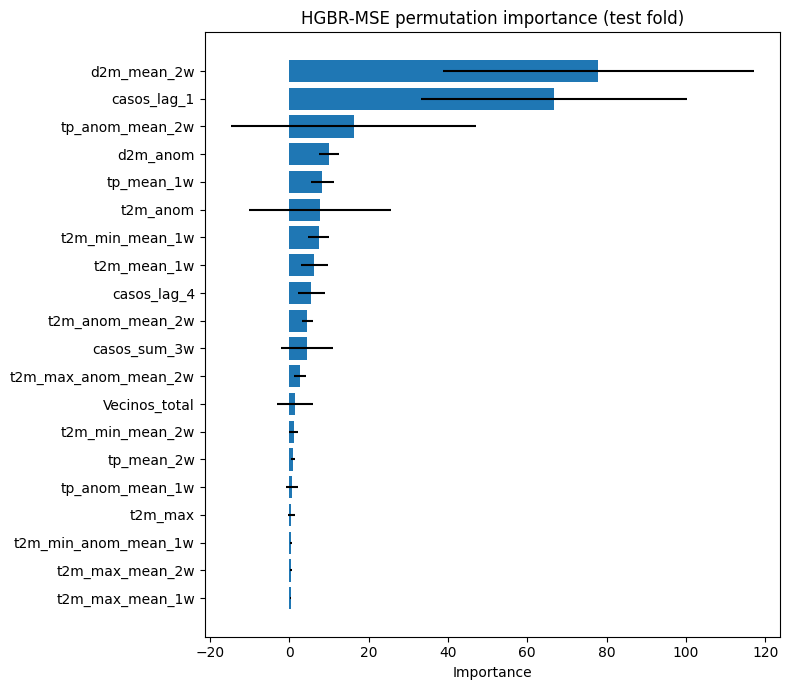

[WARN] No hay figuras abiertas tras 'HGBR-MSE permutation importance (test fold)'.


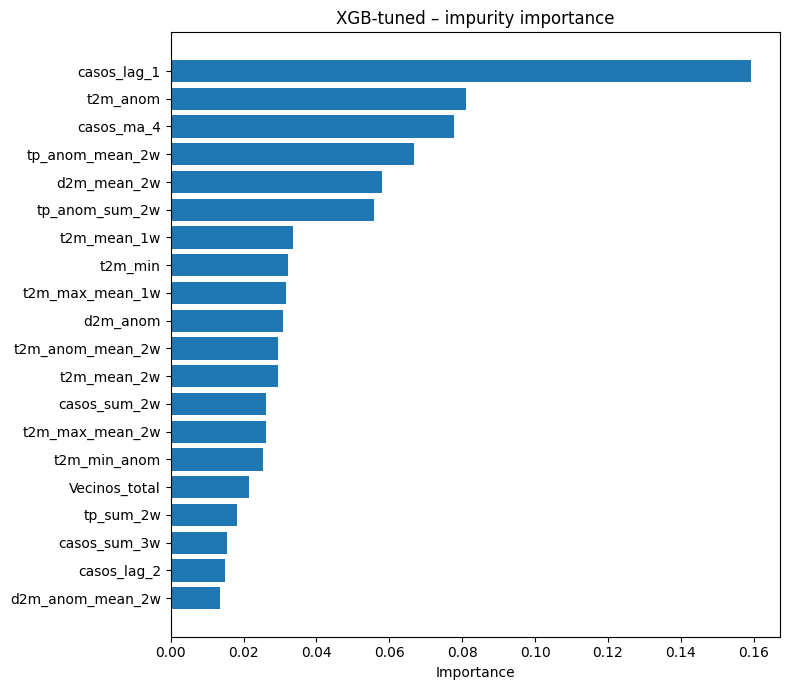

[WARN] No hay figuras abiertas tras 'XGB-tuned – impurity importance'.


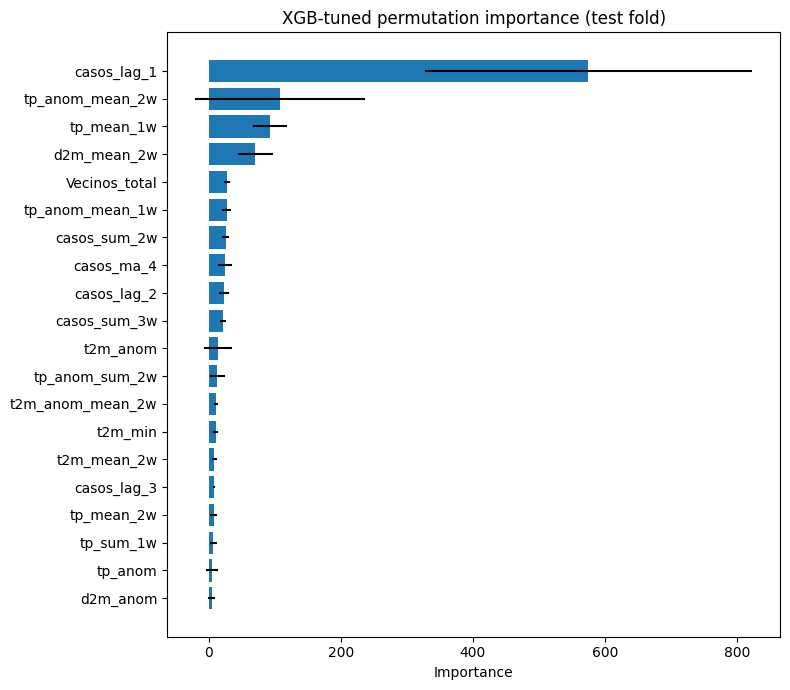

[WARN] No hay figuras abiertas tras 'XGB-tuned permutation importance (test fold)'.


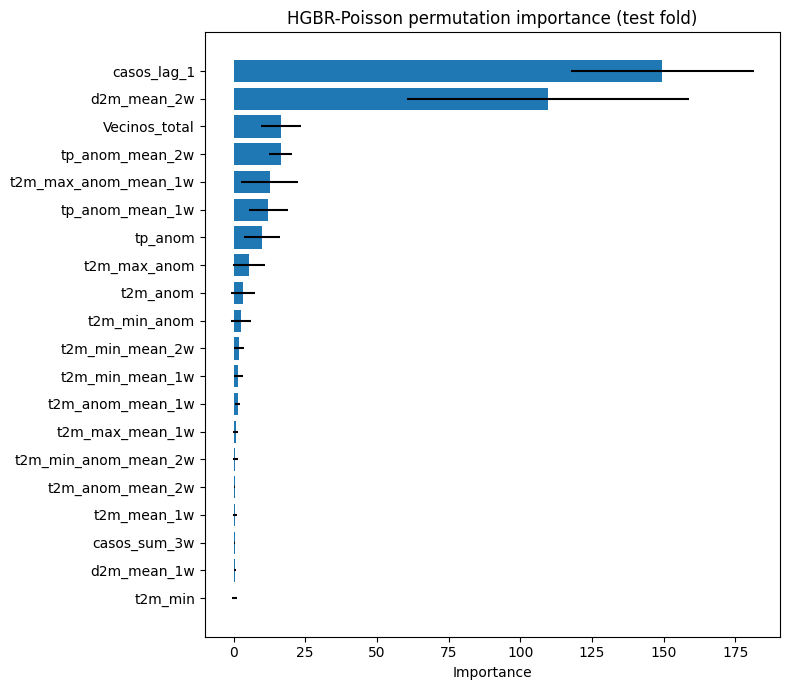

[WARN] No hay figuras abiertas tras 'HGBR-Poisson permutation importance (test fold)'.
cwd: C:\Users\Nainh\Proton Drive\nainho1306\My files\Licitacion\Plataforma prevencion Dengue\Modelo
OUTDIR: C:\Users\Nainh\Proton Drive\nainho1306\My files\Licitacion\Plataforma prevencion Dengue\Modelo\results\figs


In [ ]:
import numpy as np, pandas as pd
from copy import deepcopy
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# === utilidades ===
def fit_on_last_fold(model, df, feat_list, splits, target='casos'):
    """Entrena model en el último fold (train del último split) con imputación mediana."""
    (tr_idx, te_idx) = list(splits)[-1]
    Xtr = df.loc[tr_idx, feat_list]
    ytr = df.loc[tr_idx, target].to_numpy()
    pipe = make_pipeline(SimpleImputer(strategy='median'), deepcopy(model))
    pipe.fit(Xtr, ytr)
    return pipe, (tr_idx, te_idx)

def try_impurity_importance(pipe):
    """Devuelve importancias por impureza si existen (GB/XGB/ET tienen .feature_importances_)."""
    # el último step del pipeline es el estimador
    est = pipe.steps[-1][1]
    attr = None
    for cand in ('feature_importances_', 'coef_'):
        if hasattr(est, cand):
            attr = cand; break
    if attr is None:
        return None
    imp = getattr(est, attr)
    imp = np.abs(imp)
    if imp.ndim > 1:  # por si fuera modelo lineal multi-salida
        imp = imp.mean(axis=0)
    return imp

def get_permutation_importance(pipe, X, y, n_repeats=10, random_state=42):
    pi = permutation_importance(pipe, X, y, scoring='neg_mean_squared_error',
                                n_repeats=n_repeats, random_state=random_state, n_jobs=-1)
    return pi.importances_mean, pi.importances_std

def plot_hbar(importances, features, title, err=None, top=20):
    order = np.argsort(importances)[::-1][:top]
    vals  = importances[order]
    labs  = np.array(features)[order]
    errs  = None if err is None else err[order]
    plt.figure(figsize=(8, max(4, 0.35*len(vals))))
    plt.barh(range(len(vals)), vals, xerr=errs)
    plt.yticks(range(len(vals)), labs)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# === prepara datos del fold ===
feat_list = features[f]          # <-- tu selección actual
y_col = 'casos'                  # o 'incidencia'
Xfull = df_model[feat_list]
yfull = df_model[y_col].to_numpy()

# === modelo 1: GB-log-smear ===
import re


model_sel='XGB-tuned'#'HGBR-MSE'#XGB-tuned'#'HGBR-MSE'
models_sels=['XGB-tuned','HGBR-MSE','GB-BlendQ80-w30']
OUTDIR = Path("results/figs")
def _savefig(title):
    slug = re.sub(r'[^-\w]+', '_', title).strip('_').lower()
    plt.gcf().savefig(OUTDIR / f"{slug}.png", dpi=200, bbox_inches="tight")
    plt.close()

def graph_importance(model_sel):
    # pipe1, (tr1, te1) = fit_on_last_fold(models[], df_model, feat_list, splits, target=y_col)
    pipe1, (tr1, te1) = fit_on_last_fold(models[model_sel], df_model, feat_list, splits, target=y_col)
    #
    # impurity (si disponible)
    imp1_imp = try_impurity_importance(pipe1)
    if imp1_imp is not None:
        plot_hbar(imp1_imp, feat_list, model_sel+" – impurity importance", top=20)

    # permutation (robusto para cualquier wrapper)
    Xte1 = df_model.loc[te1, feat_list]
    yte1 = df_model.loc[te1, y_col].to_numpy()
    imp1_perm_mean, imp1_perm_std = get_permutation_importance(pipe1, Xte1, yte1, n_repeats=10, random_state=42)
    title = model_sel + " permutation importance (test fold)"
    plot_hbar(imp1_perm_mean, feat_list, title, err=imp1_perm_std, top=20)
    _savefig(title)
for m in df_results["Modelo"][:3]:
    graph_importance(m)


In [64]:
print(folds_h.columns)

Index(['Fold', 'h', 'RMSE_model', 'R2_model', 'RMSE_naive_last',
       'R2_naive_last', 'RMSE_naive_seas', 'R2_naive_seas', 'RMSE_macro_model',
       'MAE_macro_model'],
      dtype='object')


In [66]:
from pathlib import Path
import matplotlib.pyplot as plt
Path("results/figs").mkdir(parents=True, exist_ok=True)

# Predicción vs Observado (ajusta y_true/y_pred a tus variables)
plt.figure()
plt.plot(y_true, label="observado")
plt.plot(y_pred, label="predicho")
plt.title("Predicción vs Observado (semanal)")
plt.legend()
plt.savefig("results/figs/pred_vs_obs.png", dpi=150, bbox_inches="tight")
plt.close()

# (Opcional) Curva ROC si emites probabilidad de brote (clasificación)
# from sklearn.metrics import RocCurveDisplay
# RocCurveDisplay.from_predictions(y_true_cls, y_score_cls)
# plt.title("ROC – alerta de brote")
# plt.savefig("results/figs/roc_curve.png", dpi=150, bbox_inches="tight")
# plt.close()

print("✅ Guardadas figuras en results/figs/")


✅ Guardadas figuras en results/figs/
